### ### Content Analysis News Media Outlets- Inmigration Posts

### Topic Modeling 

In [78]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer

# spacy for lemmatization
import spacy

#nltk
from nltk.corpus import stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [79]:
def clean_address(row):
    name =  row.lower().split('/')
    if  row.lower().startswith('https') or  row.lower().startswith('http'):       
        return name[3]
    elif row.lower().startswith('www'):
        return name[1] 
    elif row.lower().startswith('facebook'):
        return name[1]
    else:
        print("Not found", row)
        return None

## 1. Reads  Info
Reads the information from all the posts from the studied period

In [80]:
import os
os.getcwd()

'/Users/claudia/Desktop/Latinx2020'

In [81]:

#path = "Latinx2020/"
posts = pd.read_csv("FB_groups_News_Media_Outlets_immigration.csv")
#We rename the colum Page Name to be able to concat with Group Posts
posts.rename(columns={'Page Name':'Group Name'}, inplace=True)
posts.shape

(451, 38)

In [82]:
posts['URL']

0              https://www.facebook.com/wearemitu/posts/2788877618079329
1             https://www.facebook.com/hiplatinas/posts/2890351551251601
2              https://www.facebook.com/NBCLatino/posts/3495283713889633
3              https://www.facebook.com/NBCLatino/posts/3525170224234315
4              https://www.facebook.com/Remezcla/posts/10158981375939267
                                     ...                                
446    https://www.facebook.com/ReflejosNewspaper/posts/3702712066429598
447             https://www.facebook.com/BDNnews1/posts/3385460348168937
448             https://www.facebook.com/fusiontv/posts/1619501188211337
449         https://www.facebook.com/lavozhouston/posts/3409567122462093
450          https://www.facebook.com/LatinTrends/posts/3808514842492538
Name: URL, Length: 451, dtype: object

## 9. Filter the most relevant columns
### Add column to concat Message, Description, Link Text

In [83]:
concat_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('') + (' ' + posts['Link']).fillna('')
posts['MessageDescr'] = concat_message

concat_just_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('')
posts['MessageOnly'] = concat_just_message

In [84]:
posts.columns

Index(['Unnamed: 0', 'Group Name', 'User Name', 'Facebook Id',
       'Likes at Posting', 'Created', 'Type', 'Likes', 'Comments', 'Shares',
       'Love', 'Wow', 'Haha', 'Sad', 'Angry', 'Care', 'Video Share Status',
       'Post Views', 'Total Views', 'Total Views For All Crossposts',
       'Video Length', 'URL', 'Message', 'Link', 'Final Link', 'Image Text',
       'Link Text', 'Description', 'Sponsor Id', 'Sponsor Name',
       'Total Interactions',
       'Total Interactions (weighted  —  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )',
       'Overperforming Score', 'clean_url', 'State', 'Facebook',
       'MessageDescr', 'MessageOnly'],
      dtype='object')

In [92]:
posts["Created"].head(5)

0    2020-10-05 21:00:11 EDT
1    2020-09-18 09:53:54 EDT
2    2020-10-20 18:46:30 EDT
3    2020-10-31 17:49:32 EDT
4    2020-09-12 21:40:01 EDT
Name: Created, dtype: object

In [93]:
posts['converted_date'] = pd.to_datetime(posts["Created"])
posts['converted_date']

0     2020-10-05 21:00:11-04:00
1     2020-09-18 09:53:54-04:00
2     2020-10-20 18:46:30-04:00
3     2020-10-31 17:49:32-04:00
4     2020-09-12 21:40:01-04:00
                 ...           
446   2020-10-16 16:50:26-04:00
447   2020-10-20 10:02:09-04:00
448   2020-10-22 18:02:15-04:00
449   2020-10-20 12:00:52-04:00
450   2020-11-03 13:57:13-05:00
Name: converted_date, Length: 451, dtype: datetime64[ns, tzlocal()]

In [94]:
posts['converted_date'] = posts['converted_date'].dt.date
posts['converted_date'] 

0      2020-10-05
1      2020-09-18
2      2020-10-20
3      2020-10-31
4      2020-09-12
          ...    
446    2020-10-16
447    2020-10-20
448    2020-10-22
449    2020-10-20
450    2020-11-03
Name: converted_date, Length: 451, dtype: object

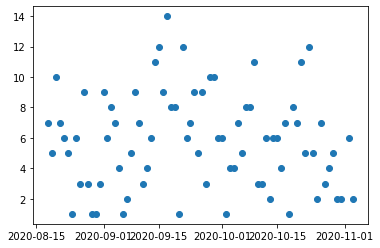

In [96]:
import matplotlib.pyplot as plt
group_date = posts.groupby('converted_date').agg({'Facebook Id':'count'}).reset_index()
group_date
plt.scatter(group_date['converted_date'],group_date['Facebook Id'] )
plt.show()

In [11]:
posts[posts['Link Text'].str.lower().str.contains("í", na = False)].head(1)

,Unnamed: 0,Group Name,User Name,Facebook Id,Likes at Posting,Created,Type,Likes,Comments,Shares,...,Sponsor Name,Total Interactions,Total Interactions (weighted — Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x ),Overperforming Score,clean_url,State,Facebook,MessageDescr,MessageOnly,converted_date
75,185501,NY1 Noticias,NY1Noticias,9.183935e+10,65768.0,2020-09-26 20:30:11 EDT,Link,61,3,18,...,NaN,106,106,1.32,ny1noticias,New York,https://www.facebook.com/NY1Noticias/,"""No importa en qué llegas, en avión, en carro,...","""No importa en qué llegas, en avión, en carro,...",2020-09-26 20:30:11-04:00


In [12]:
#!/usr/bin/env python
import re

text = u'This is a smiley face \U0001f602'
print(text) # with emoji

def deEmojify(text):
    
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          
                           "]+", flags = re.UNICODE)
    
    
    return regrex_pattern.sub(r'',text)

print(deEmojify(text))

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

This is a smiley face 😂
This is a smiley face 


In [13]:

posts['Group Name']=posts['Group Name'].apply(deEmojify)
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace('"', ''))
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace(',', ''))
posts['Facebook Id'] = posts['Facebook Id'].astype(int)



### 4. US states

In [14]:
us_states = pd.DataFrame({'State':['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','District of Columbia','Florida',
             'Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts',
             'Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico',
             'New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina',
             'South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']})

##  Count posts in general by state

In [15]:

df_count = posts.groupby(['State']).agg({'Facebook Id':'count'}).reset_index() 

df_count.columns = ['State','Posts_Counts']
df_count.sort_values(by=['State'], ascending=True,inplace=True)
df_count.fillna(0, inplace=True)
df_count['Posts_Counts'] = df_count['Posts_Counts'].astype(int)
df_count.head(10)



,State,Posts_Counts
0,Alabama,1
1,Arizona,6
2,California,71
3,Colorado,13
4,Connecticut,3
5,Delaware,1
6,District of Columbia,2
7,Florida,19
8,Georgia,3
9,Idaho,1


In [17]:
#us_states['State'] = us_states['State']
from functools import reduce
data_frames = [df_count, us_states]
missing_states  = reduce(lambda  left,right: pd.merge(left,right,on=['State'],
                                            how='outer'), data_frames)
missing_states.fillna(0, inplace=True)
missing_states['Posts_Counts'] = missing_states['Posts_Counts'].astype(int)
missing_states

,State,Posts_Counts
0,Alabama,1
1,Arizona,6
2,California,71
3,Colorado,13
4,Connecticut,3
5,Delaware,1
6,District of Columbia,2
7,Florida,19
8,Georgia,3
9,Idaho,1


## 3. Which groups are publishing the majority of the content

In [18]:
group = posts.groupby(['Group Name'])
final_groups = group.agg({'Facebook Id':'count'}).sort_values(by='Facebook Id',ascending=False)
final_groups

,Facebook Id
Group Name,
Al DA News Media,51
We are mit,39
NOTICIAS DMV,33
Hola America,32
Remezcla,21
...,...
MiamiDiario,1
Miniondas Newspaper,1
Neta,1


In [19]:


republicans = "donald trump|trump|mike pence|nikki haley|john mccain|susan collins|rand paul|chris christie|\
jeff flake|roger stone|george bush|george w. bush|herbert hoover|charles curtis|sarah palin|bill weld|\
rocky de la fuente|joe walsh|mark sanford|herman cain|brad parscale|melania trump|richard nixon|jared kushner|\
ivanka trump|lindsey graham|newt gingrich|rudy giuliani|william barr|mitch mcconnell|gop|republican|\
republicans|republicano|republicanos"


#democrats
democrats = 'joe biden|biden|hillary clinton|kamala harris|michelle obama|bernie sanders|andrew cuomo|tom pérez|\
harry reid|bill clinton|barack obama|adlai stevenson ii|pete buttigieg|michael bennet|deval patrick|andrew yang|\
amy klobuchar|tom steyer|michael bloomberg|elizabeth warren|tulsi gabbard|geraldine ferraro|tony evers|\
nancy pelosi|josh shapiro|democrat|democrats|democratas|democrata'


general_politics = "kanye west|jo jorgensen|spike cohen|howie hawkins|angela walker|don blankenship|gloria la riva|\
brian t. carroll|brock pierce|phil collins|bill hammons|jerome segal|blake huber|mark charles|dario hunter|\
joseph kishore|alyson kennedy|jade simmons|joe mchugh|kyle kopitke|amy coney barrett|ruth bader ginsburg|\
george floyd|oprah winfrey|breonna taylor|geng shuang|philip goldberg|jho low|chris krebs|chris wallace|\
christopher a. wray|louis dejoy|merrick garland|steve scully|susan page|kristen welker|urszula gacek|\
michael georg link|william h. frey|ann selzer|samuel alito|tucker carlson|cynthia stephens|sidney powell|\
shelby pierson|joseph maguire"



posts_democrats = posts.copy()
posts_democrats = posts[posts['MessageDescr'].str.lower().str.contains(democrats   ,na = False)]
print('democrats', posts_democrats.shape)

posts_republicans = posts.copy()
posts_republicans = posts[posts['MessageDescr'].str.lower().str.contains(republicans   ,na = False)]
print('republicans', posts_republicans.shape)

posts_general_politics = posts.copy()
posts_general_politics = posts[posts['MessageDescr'].str.lower().str.contains(general_politics   ,na = False)]
print('general politics', posts_general_politics.shape)


posts_none = posts.copy()
posts_none = posts[~posts['MessageDescr'].str.lower().str.contains(general_politics + '|' + democrats + '|' +republicans ,na = False)]
print('none',posts_none['MessageDescr'].shape)

posts['Link Text'].isna().sum()

democrats (35, 39)
republicans (86, 39)
general politics (2, 39)
none (348,)


57

### 6.Filter Posts per each political party
How much each candidate talked about all the topics that Latinx cared about

In [20]:
posts_democrats['MessageDescr'][3:6]

20    Trump’s immigration adviser Stephen Miller has...
24    Trump mocks some undocumented immigrants as ha...
39    U.S. President Donald Trump visited Yuma Tuesd...
Name: MessageDescr, dtype: object

In [21]:
posts_democrats.columns

Index(['Unnamed: 0', 'Group Name', 'User Name', 'Facebook Id',
       'Likes at Posting', 'Created', 'Type', 'Likes', 'Comments', 'Shares',
       'Love', 'Wow', 'Haha', 'Sad', 'Angry', 'Care', 'Video Share Status',
       'Post Views', 'Total Views', 'Total Views For All Crossposts',
       'Video Length', 'URL', 'Message', 'Link', 'Final Link', 'Image Text',
       'Link Text', 'Description', 'Sponsor Id', 'Sponsor Name',
       'Total Interactions',
       'Total Interactions (weighted  —  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )',
       'Overperforming Score', 'clean_url', 'State', 'Facebook',
       'MessageDescr', 'MessageOnly', 'converted_date'],
      dtype='object')

In [22]:
df_dem = posts_democrats['State'].value_counts().reset_index()
df_dem.columns = ['State','Count']

In [23]:
df_rep = posts_republicans['State'].value_counts().reset_index()
df_rep.columns = ['State','Count']

In [24]:
df_gen_pol = posts_general_politics['State'].value_counts().reset_index()
df_gen_pol.columns = ['State','Count']

In [25]:
df_gen_info = posts_none['State'].value_counts().reset_index()
df_gen_info.columns = ['State','Count']

In [26]:
from functools import reduce
data_frames = [df_dem, df_rep,df_gen_pol,df_gen_info]
df_all = reduce(lambda  left,right: pd.merge(left,right,on=['State'],
                                            how='outer'), data_frames)
df_all.columns = ['State','Posts_Dem','Posts_Rep', 'Posts_Gen_Pol','Post_Gen_Info']
df_all.sort_values(by=['State'], ascending=True,inplace=True)
df_all.fillna(0, inplace=True)
df_all['Posts_Dem'] = df_all['Posts_Dem'].astype(int)
df_all['Posts_Rep'] = df_all['Posts_Rep'].astype(int)
df_all['Posts_Gen_Pol'] = df_all['Posts_Gen_Pol'].astype(int)
df_all['Post_Gen_Info'] = df_all['Post_Gen_Info'].astype(int)
df_all

,State,Posts_Dem,Posts_Rep,Posts_Gen_Pol,Post_Gen_Info
4,Alabama,1,1,0,0
7,Arizona,1,1,0,5
2,California,5,23,0,45
11,Colorado,0,2,0,11
23,Connecticut,0,0,0,3
29,Delaware,0,0,0,1
26,District of Columbia,0,0,0,2
3,Florida,1,7,0,12
22,Georgia,0,0,0,3
16,Idaho,0,1,0,0


In [27]:
dummy = posts_democrats[posts_democrats['MessageDescr'].str.contains("gop")]
pd.set_option('display.max_colwidth', 400)
dummy['MessageDescr']

Series([], Name: MessageDescr, dtype: object)

## FB Groups Political Posts

In [28]:
posts_political =  pd.concat([posts_democrats,posts_republicans,posts_general_politics])

#posts_political = df_posts_state[df_posts_state['MessageDescr'].str.lower().str.contains(democrats + '|' +republicans+ '|' +general_politics, na = False)]
df_political = posts_political['State'].value_counts().reset_index()
df_political.columns = ['State','Count']
df_political

,State,Count
0,New York,36
1,California,28
2,Pennsylvania,20
3,Florida,8
4,Wisconsin,4
5,Iowa,4
6,Illinois,3
7,Massachusetts,3
8,Missouri,2
9,Maryland,2


## Tokenize words and Clean-up text

In [29]:
content = posts.copy()
content['MessageDescr']

0      He has also released a plan that would fully reinstate DACA and work on legislation to offer a pathway to citizenship. #na Presidential candidate Joe Biden reminded his supporters that he intends to freeze deportations during the first 100 days to reform the immigration system. Joe Biden Promises To Freeze Deportations During His First 100 Days If Elected https://wearemitu.com/things-that-matt...
1      #Repost @alex.albadree ・・・ Nurse Wooten’s Bravery Should Be Uplifted Now!!          Nurse Dawn Wooten shows us what courage looks like. Her bravery should be uplifted by all Americans for exposing the Trump camp horrors.          Share her story and donate to her GoFund me Campaign.          Wooten worked at an Immigration and Customs Enforcement facility, filed a whistleblower complaint with ...
2      BREAKING: Lawyers appointed by federal judge to identify migrant families who were separated by the Trump admin. say they have yet to track down the parents of 545 children, a cou

In [30]:
content['cleanMessage'] = content['MessageDescr'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
content['cleanMessage'].shape

(451,)

In [31]:
# Convert to list
data = content.cleanMessage.tolist()

In [32]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


In [33]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:2])

[['he', 'has', 'also', 'released', 'plan', 'that', 'would', 'fully', 'reinstate', 'daca', 'and', 'work', 'on', 'legislation', 'to', 'offer', 'pathway', 'to', 'citizenship', 'na', 'presidential', 'candidate', 'joe', 'biden', 'reminded', 'his', 'supporters', 'that', 'he', 'intends', 'to', 'freeze', 'deportations', 'during', 'the', 'first', 'days', 'to', 'reform', 'the', 'immigration', 'system', 'joe', 'biden', 'promises', 'to', 'freeze', 'deportations', 'during', 'his', 'first', 'days', 'if', 'elected'], ['repost', 'alex', 'albadree', 'nurse', 'wooten', 'bravery', 'should', 'be', 'uplifted', 'now', 'nurse', 'dawn', 'wooten', 'shows', 'us', 'what', 'courage', 'looks', 'like', 'her', 'bravery', 'should', 'be', 'uplifted', 'by', 'all', 'americans', 'for', 'exposing', 'the', 'trump', 'camp', 'horrors', 'share', 'her', 'story', 'and', 'donate', 'to', 'her', 'gofund', 'me', 'campaign', 'wooten', 'worked', 'at', 'an', 'immigration', 'and', 'customs', 'enforcement', 'facility', 'filed', 'whistle

#### Creating Bigram and Trigram Models

In [34]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['he', 'has', 'also', 'released', 'plan', 'that', 'would', 'fully', 'reinstate', 'daca', 'and', 'work', 'on', 'legislation', 'to', 'offer', 'pathway', 'to', 'citizenship', 'na', 'presidential', 'candidate', 'joe_biden', 'reminded', 'his', 'supporters', 'that', 'he', 'intends', 'to', 'freeze', 'deportations', 'during', 'the', 'first', 'days', 'to', 'reform', 'the', 'immigration', 'system', 'joe_biden', 'promises', 'to', 'freeze', 'deportations', 'during', 'his', 'first', 'days', 'if', 'elected']


## Remove Stopwords, Make Bigrams and Lemmatize

In [35]:
stop_words = stopwords.words('spanish')
stop_words.extend(stopwords.words('english'))
stop_words.extend(['su','sus','al','de','en','el','tal','con','mas','si','dos','pm','ser','ex','could','like','would','get','many','much','\ufeff1'])

In [36]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [37]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#!python3 -m spacy download es_core_news_sm
nlp = spacy.load('es_core_news_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [38]:
print(data_words_nostops[1:2])

[['repost', 'alex', 'albadree', 'nurse', 'wooten', 'bravery', 'uplifted', 'nurse', 'dawn', 'wooten', 'shows', 'us', 'courage', 'looks', 'bravery', 'uplifted', 'americans', 'exposing', 'trump', 'camp', 'horrors', 'share', 'story', 'donate', 'gofund', 'campaign', 'wooten', 'worked', 'immigration', 'customs', 'enforcement', 'facility', 'filed', 'whistleblower', 'complaint', 'department', 'homeland', 'security', 'inspector', 'general', 'dawn', 'wooten', 'licensed', 'practical', 'nurse', 'bravely', 'came', 'forward', 'alert', 'american', 'atrocities', 'committed', 'ice', 'nurse', 'irwin', 'county', 'detention', 'center', 'bravely', 'coming', 'forward', 'wooten', 'prompted', 'calls', 'federal', 'investigation', 'claims', 'immigration', 'customs', 'enforcement', 'detention', 'center', 'worked', 'performing', 'mass', 'hysterectomies', 'wooten', 'stated', 'complaint', 'everybody', 'uterus', 'cannot', 'bad', 'moreover', 'wooten', 'said', 'hispanics', 'treated', 'worst', 'facility', 'dawnwooten',

## Bag of Words

In [39]:
def combine_words(word1,word2,dictionary):

    if word1 in dictionary and word2 in dictionary:
        concat_name = word1+" / "+word2
        dictionary[concat_name] = dictionary[word1] + dictionary[word2]
        dictionary.pop(word1, None)
        dictionary.pop(word2, None)
        result = dictionary.pop(word1, None)
        result = dictionary.pop(word2, None)
    return dictionary

In [40]:
flat_list_words = [item for sublist in data_lemmatized for item in sublist]
count_words = Counter(flat_list_words)

In [41]:
final_dict = combine_words('donald','trump',count_words)
final_dict = combine_words('joe','biden',count_words)
final_dict = combine_words('kamala','harris',count_words)
final_dict = combine_words('american','america',count_words)
final_dict = combine_words('estados','unidos',count_words)
final_dict = combine_words('voters','vote',count_words)
final_dict = combine_words('mexico','mexican',count_words)
final_dict = combine_words('casa','blanca',count_words)
final_dict = combine_words('venezuela','venezuelans',count_words)
final_dict = combine_words('latino','latinos',count_words)
final_dict = combine_words('american / america','americans',count_words)
final_dict = combine_words('voters / vote','voting',count_words)
final_dict = combine_words('puerto','rico',count_words)
final_dict = combine_words('communism','communist',count_words)
final_dict = combine_words('ee','uu',count_words)
final_dict = combine_words('united','states',count_words)
final_dict = combine_words('president','presidente',count_words)
final_dict = combine_words('democrat','democrats',count_words)
final_dict = combine_words('informacion','informar',count_words)
final_dict = combine_words('covid','coronavirus',count_words)
final_dict = combine_words('democrat / democrats','democratas',count_words)

In [42]:
final_dict.most_common(1000)

[('immigration', 417),
 ('inmigracion', 142),
 ('izar', 113),
 ('trump', 102),
 ('latino', 82),
 ('immigrant', 80),
 ('said', 56),
 ('legal', 55),
 ('inmigrante', 55),
 ('paoli_law', 49),
 ('abogado', 48),
 ('also', 47),
 ('policy', 47),
 ('covid / coronavirus', 45),
 ('migrant', 44),
 ('childrar', 44),
 ('mexico', 43),
 ('unido', 43),
 ('year', 41),
 ('president / presidente', 40),
 ('border', 38),
 ('community', 38),
 ('pandemic', 34),
 ('percent', 34),
 ('federal', 33),
 ('latest', 33),
 ('americar', 32),
 ('ice', 32),
 ('famili', 32),
 ('voters / vote / voting', 32),
 ('necesita', 31),
 ('news', 30),
 ('time', 30),
 ('peoplir', 30),
 ('pregunta', 30),
 ('women', 29),
 ('georgia', 29),
 ('familia', 29),
 ('informacion / informar', 29),
 ('photo', 28),
 ('covidir', 28),
 ('country', 27),
 ('new', 27),
 ('performing', 26),
 ('parent', 26),
 ('deportation', 25),
 ('today', 25),
 ('informed', 25),
 ('dacar', 24),
 ('citizenship', 24),
 ('new_york', 24),
 ('say', 24),
 ('hola_americo', 2

In [43]:
docs = ([' '.join(ele) for ele in data_lemmatized] )


In [44]:
cv=CountVectorizer() 
word_count_vector=cv.fit_transform(docs)
#word_count_vector.toarray()

# Convert bow_matrix into a DataFrame
bow_df = pd.DataFrame(word_count_vector.toarray())

# Map the column names to vocabulary 
bow_df.columns = cv.get_feature_names()

# Print bow_df
print(bow_df)

     aar  abajo  abandoning  abel  aberrations  abierto  ability  able  \
0      0      0           0     0            0        0        0     0   
1      0      0           0     0            0        0        0     0   
2      0      0           0     0            0        0        0     0   
3      0      0           0     0            0        0        0     0   
4      0      0           0     0            0        0        0     0   
..   ...    ...         ...   ...          ...      ...      ...   ...   
446    0      0           0     0            0        0        0     0   
447    0      0           0     0            0        0        0     0   
448    0      0           0     0            0        0        0     0   
449    0      0           0     0            0        0        0     0   
450    0      0           0     0            0        0        0     0   

     abogada  abogado  ...  án  él  ín  ús  𝗜𝗡𝗠𝗜𝗚𝗥𝗔𝗖𝗜o𝗡  𝗶𝗻𝗰𝗿𝗲𝗺𝗲𝗻𝘁𝗼  \
0          0        0  ...   0   0   0  

In [45]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [46]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
immigration,1.380341
inmigracion,2.549334
izar,2.731656
trump,3.124698
immigrant,3.242481
...,...
hernandez,6.420535
heroesatl,6.420535
heroeshispano,6.420535
opens,6.420535


In [47]:
# count matrix 
count_vector=cv.transform(docs) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [48]:
feature_names = cv.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df = df[(df != 0).all(1)]
df.sort_values(by=["tfidf"],ascending=False).to_csv("outlets_tfidf.csv")

In [49]:
df

,tfidf
also,0.104593
candidate,0.160484
citizenship,0.120065
dacar,0.134958
day,0.286692
deportations,0.333980
elected,0.187200
first,0.237284
freeze,0.374399
fully,0.166990


In [50]:
word = df.index[1]
content["lowercase"] = content['cleanMessage'].apply(lambda x: x.lower())
word_messages = content[content['lowercase'].str.contains(word)]
word_messages = word_messages['lowercase'].value_counts(ascending=False).rename_axis('unique_messages').reset_index(name='counts')
word_messages.to_csv(word + "_messages.csv")
word_messages

,unique_messages,counts
0,former presidential candidates julián castro (d-tx) and sen. bernie sanders (d-vt) headlined a virtual town hall hosted by univision tuesday night on national voter registration day,3
1,he has also released a plan that would fully reinstate daca and work on legislation to offer a pathway to citizenship. #na presidential candidate joe biden reminded his supporters that he intends to freeze deportations during the first 100 days to reform the immigration system. joe biden promises to freeze deportations during his first 100 days if elected,1
2,u.s. president donald trump visited yuma tuesday for the second time this year — the third visit in his four-year presidency — to deliver remarks on democratic candidate joe biden’s “failures on immigration and border security” as part of a campaign rally ahead of november’s general election. yuma — u.s. president donald trump visited here tuesday for the second time this year — the third visi...,1
3,"cesar lopez of netflix’s “immigration nation” to visit iowa and discuss the plight of immigrants in the u.s. military ** saturday, august 22nd at 2:00 p.m. cst, dsm** latino civil rights organizations, lulac council 307 & forward latino to host star of national documentary at des moines capitol. des moines, ia – time magazine has called netflix’s documentary “immigration nation” 2020’s most im...",1
4,"🗳 17 days away! november 3 is #electionday 🇺🇸 source @eva.nohemi ・・・ 🗣 i am voting for those who can’t, for immigration reform, and for real change that’ll improve america and the lives of every single person in this country, not just the rich and powerful. i became a citizen last year, so this will be the first time i exercise my right to vote in a presidential election and i’m making my voic...",1
5,"nearly two-thirds of latino voters concerned about orderly transition of power with election day just two weeks away, covid-19 remains the top issue as 16 percent of latino voters have already voted washington, d.c. – results from the seventh week of the 2020 latino weekly tracking poll from naleo educational fund and latino decisions offer exclusive insight into the latino electorate’s views ...",1


### Repeated messages

In [51]:
content['Total Interactions']=content['Total Interactions'].astype(str).str.replace(',', '').astype(int)
results = content.groupby(['MessageDescr','Link']).aggregate({'MessageDescr': 'count','Likes': 'sum','Comments': 'sum', 'Shares': 'sum', 'Love': 'sum', 'Wow': 'sum', 'Haha': 'sum', 'Sad': 'sum',
       'Angry': 'sum', 'Care': 'sum','Total Interactions':'sum'})
results.rename(columns={"MessageDescr": "Counts"}, inplace=True)

results.to_csv("mostpopularNewsMedia.csv")

In [97]:
results.sort_values(by='Counts',ascending=False)

,,Counts,Likes,Comments,Shares,Love,Wow,Haha,Sad,Angry,Care,Total Interactions
MessageDescr,Link,,,,,,,,,,,
"Advocates aid immigrant families with schools reopening Keep on it. As the city’s public schools prepare to reopen, advocates are urging immigrant families to stay on top of the latest information on reopening plans. “We have to, as a city right now, make all the right preparations to ensure that everyone’s health and safety and educational progress at school happens,” said Kim Sykes, Director of Education Policy for the New York Immigration Coalition (NYIC), at a virtual press briefing held on Tues., Sept. 8. “A key part of ensuring real safety and being truly prepared to open is having a system in place that… gets information to immigrant families in their home language so that they are informed as soon as other parents are informed,” she said. Sykes said the launch of remote school orientations on September 16 would be essential for helping students to reconnect with teachers while reviewing school procedures as well as safety protocols. However, she cautioned that many immigrant families have reported not having technology to begin remote learning. “We’re encouraging families to fill out a device request form that is online and also to contact their school,” she said. “We’re encouraging them to do this now so they can get the device for September 16.” Continúen. Mientras las escuelas públicas de la ciudad se preparan para reabrir, los defensores instan a las familias inmigrantes a mantenerse al tanto de la información más reciente sobre los planes de reapertura. “They are not alone”""No están solos"" - The Bronx Free Press https://thebronxfreepress.com/they-are-not-aloneno-estan-solos/",https://thebronxfreepress.com/they-are-not-aloneno-estan-solos/,5,3,0,0,0,0,0,0,0,0,3
"Advocates aid immigrant families with schools reopening Keep on it. As the city’s public schools prepare to reopen, advocates are urging immigrant families to stay on top of the latest information on reopening plans. “We have to, as a city right now, make all the right preparations to ensure that everyone’s health and safety and educational progress at school happens,” said Kim Sykes, Director of Education Policy for the New York Immigration Coalition (NYIC), at a virtual press briefing held on Tues., Sept. 8. “A key part of ensuring real safety and being truly prepared to open is having a system in place that… gets information to immigrant families in their home language so that they are informed as soon as other parents are informed,” she said. Sykes said the launch of remote school orientations on September 16 would be essential for helping students to reconnect with teachers while reviewing school procedures as well as safety protocols. However, she cautioned that many immigrant families have reported not having technology to begin remote learning. “We’re encouraging families to fill out a device request form that is online and also to contact their school,” she said. “We’re encouraging them to do this now so they can get the device for September 16.” Continúen. Mientras las escuelas públicas de la ciudad se preparan para reabrir, los defensores instan a las familias inmigrantes a mantenerse al tanto de la información más reciente sobre los planes de reapertura. “They are not alone”""No están solos"" - Manhattan Times News https://www.manhattantimesnews.com/they-are-not-aloneno-estan-solos/",https://www.manhattantimesnews.com/they-are-not-aloneno-estan-solos/,5,7,0,0,0,0,0,0,0,0,7
¿Necesitas representación legal ? Somos especialistas en casos de inmigración. Llámanos ahora para una asesoría personalizada (703) - 914-0046 Paoli Law Paoli Law https://www.facebook.com/PaoliLawImmigration/videos/574169060048445/,https://www.facebook.com/PaoliLawImmigration/videos/574169060048445/,4,15,0,0,1,0,0,0,0,0,16
"The reflection of the mistreatment in ICE custody keeps unveiling itself to the public. If anyone running ICE detention centers has not noticed, t

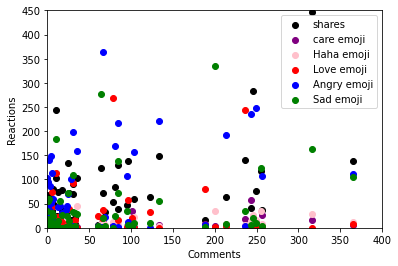

In [53]:
results.reset_index()
plt.xlim(0,400)
plt.ylim(0,450)

plt.xlabel('Comments')
plt.ylabel('Reactions')
plt.scatter(results.Comments, results.Shares,c='black',label='shares')
plt.scatter(results.Comments, results.Haha,c='purple',label='care emoji')
plt.scatter(results.Comments, results.Wow,c='pink',label='Haha emoji')
plt.scatter(results.Comments, results.Love,c='red',label='Love emoji')
plt.scatter(results.Comments, results.Angry,c='blue',label='Angry emoji')
plt.scatter(results.Comments, results.Sad,c='green',label='Sad emoji')

plt.legend()


In [56]:
#Topic Modeling
#Create the Dictionary and Corpus needed for Topic Modeling


# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]
[[('council', 1),
  ('district', 1),
  ('fees', 1),
  ('immigration', 1),
  ('inmigracion', 1),
  ('nuevo', 1),
  ('nyc', 1),
  ('october', 1),
  ('octubre', 1),
  ('partir', 1),
  ('starting', 1),
  ('tarifa', 1)]]
#Buiding the Topic Model



[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 2), (6, 1), (7, 2), (8, 2), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)]]


[[('council', 1),
  ('district', 1),
  ('fees', 1),
  ('immigration', 1),
  ('inmigracion', 1),
  ('nuevo', 1),
  ('nyc', 1),
  ('october', 1),
  ('octubre', 1),
  ('partir', 1),
  ('starting', 1),
  ('tarifa', 1)]]

In [57]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [58]:
#View the topics in LDA model
# Print the Keyword in the 10 topics
#The weights reflect how important a keyword is to that topic.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.053*"defensa" + 0.047*"centro" + 0.034*"servicio" + 0.014*"inmigrante" + '
  '0.014*"condado" + 0.012*"tambien" + 0.012*"asegurar" + 0.012*"lucro" + '
  '0.012*"fines" + 0.011*"preparing"'),
 (1,
  '0.036*"facebook" + 0.028*"helping" + 0.027*"tramit" + 0.024*"join" + '
  '0.016*"faciliti" + 0.013*"actions" + 0.013*"organizacion" + 0.013*"tonight" '
  '+ 0.012*"organizations" + 0.011*"migrant"'),
 (2,
  '0.024*"hero" + 0.020*"cruz" + 0.013*"telemundo" + 0.010*"hispano" + '
  '0.008*"bader" + 0.007*"atlanto" + 0.004*"chick" + 0.004*"bravo" + '
  '0.004*"atlantar" + 0.004*"klinke"'),
 (3,
  '0.031*"august" + 0.009*"reproductive" + 0.008*"gas" + 0.007*"nationwidir" + '
  '0.007*"color" + 0.006*"scholar" + 0.005*"injustizar" + 0.005*"facir" + '
  '0.003*"prisons" + 0.002*"prism"'),
 (4,
  '0.071*"citizenship" + 0.042*"event" + 0.024*"community" + 0.021*"help" + '
  '0.019*"texas" + 0.018*"increase" + 0.017*"fees" + 0.013*"advocacy_groups" + '
  '0.012*"documents" + 0.011*"document

In [59]:
#Compute Model Perplexity and Coherence Score
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -17.08874498806616

Coherence Score:  0.4325206412450558


In [61]:
#Visualize the topics-keywords
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.270110  0.056199       1        1  18.418201
19     0.203391  0.034003       2        1  11.039561
5      0.073548 -0.297676       3        1  10.877576
11     0.105925  0.131423       4        1   9.938883
16     0.068649 -0.007981       5        1   8.182174
7      0.033871 -0.036001       6        1   6.794783
18     0.052699 -0.000676       7        1   6.280044
14    -0.075036  0.033991       8        1   4.699010
9     -0.061142  0.025193       9        1   4.564689
6     -0.088889  0.027089      10        1   3.480061
15    -0.006887  0.007311      11        1   3.231655
12    -0.026490 -0.099938      12        1   2.235392
0     -0.077974 -0.013928      13        1   2.164130
4     -0.045876  0.023413      14        1   1.805964
13    -0.078110  0.025526      15        1   1.755041
1     -0.068112  0.016751      16        1   1.331347
17    -0.073480  0.025305      17        1   1.214908
8     -0.072236  0.018758      18        1   0.856039
2     -0.070098  0.013862      19        1   0.669235
3     -0.063861  0.017375      20        1   0.461308, topic_info=             Term        Freq       Total Category  logprob  loglift
950   inmigracion  222.000000  222.000000  Default  30.0000  30.0000
1196        unido  153.000000  153.000000  Default  29.0000  29.0000
297          izar  172.000000  172.000000  Default  28.0000  28.0000
321         legal   84.000000   84.000000  Default  27.0000  27.0000
361        latino  131.000000  131.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
3002     multitud    0.014384    1.142426  Topic20  -8.6104   1.0041
3005        noche    0.014384    1.142426  Topic20  -8.6104   1.0041
3021      policia    0.014385    1.142538  Topic20  -8.6104   1.0040
2069    education    0.014386    1.142756  Topic20  -8.6103   1.0039
3023     portland    0.014385    1.142522  Topic20  -8.6104   1.0040

[786 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1335     17  0.603908  aberrations
633       3  0.917128      abogado
633       6  0.023516      abogado
633       8  0.035274      abogado
633      12  0.011758      abogado
...     ...       ...          ...
337       2  0.375072         year
337       5  0.034097         year
337       7  0.187536         year
394       1  0.918908        years
425      10  0.448952        youth

[773 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 20, 6, 12, 17, 8, 19, 15, 10, 7, 16, 13, 1, 5, 14, 2, 18, 9, 3, 4])